# PyTorch MNIST Tutorial
In this post we will get acquainted with the basics of training a machine learning model using PyTorch. ML model development can be subdivided into the following stages 
1. Data Setup        
2. Model and Objective/Loss Specification     
3. Model Training
4. Performance Evaluation

In this tutorial, our goal is to quickly train a CNN (convolutional neural network) model going through all the four stages. The idea here isn't necessarily to introduce CNN or ML, but it is to get used to doing things in PyTorch. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which is considered to be an easy problem. 

In [1]:
# CUSTOMARY IMPORTS
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

## Data  Setup
In PyTorch we have a few concepts that can help ease the data setup process  
1. **Dataset**: each dataset (like MNIST) will have a class which implements \__getitem__() which returns an example (tuple)
2. **DataLoader**: takes a Dataset as input and outputs a generator or iterable object. One can use next() on a DataLoader object to get the next example from the dataset. The DataLoader can be setup to return a batch_size number of examples.
3. **Transforms.Compose**: applies a list of transforms from left to right on each example(s) that is returned 

Transforms can be used to augment the dataset by applying transformations such as scaling, rotations, masking, etc. For MNIST, the torchvision package has already implemented a Dataset called MNIST, where it will download the data for us automatically, if not already downloaded. Since the MNIST data is split up into different files, we also need to specify whether we wish to setup a train set DataLoader or a test set DataLoader. 

Prior to data setup, let us also define some training hyperparameters. These are not parameters in the classical sense, but they do impact the solution that we end up at. Please read the comments for more details on what they do.


In [2]:
# TRAINING HYPERPARAMETERS: 
n_epochs = 3           # How many passes through the training data  
batch_size_train = 64  # Training batch size usually in [1,256]
batch_size_test = 1000 # Test batch size (choose anything)
learning_rate = 0.01   # Learning rate for optimizer like SGD usually in [0.001, 0.1]
log_frequency = 100
random_seed = 1        
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

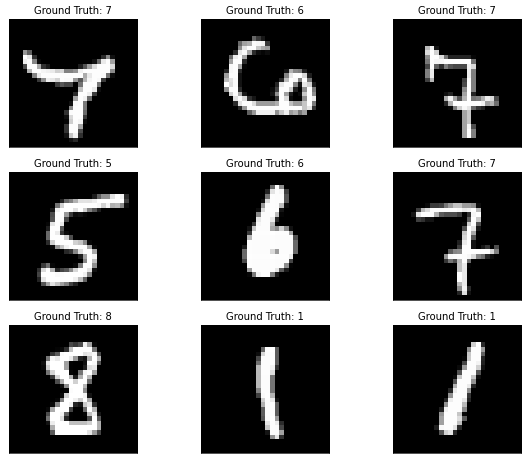

In [4]:
# The enumerate() method adds a counter to an iterable and returns an enumerate object
examples = enumerate(test_loader)
batch_idx, (example_X, example_y) = next(examples)

# VISUALIZE SOME EXAMPLES
fig=plt.figure(figsize=(10, 8), dpi=60)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_X[i][0], cmap='gray')
  plt.title("Ground Truth: {}".format(example_y[i]))
  plt.xticks([])
  plt.yticks([])

## Model Specification
All PyTorch models should inherit from the nn.Module (for automatic gradients and such). Building models in PyTorch is like Lego, we take some layers or operations like Conv2d, Linear, and then compose them in a function called forward (which is required to be defined). The forward function (also called prediction) takes the input and produces a output after processing through the model. The torch.nn.functional allows applying activation functions and dropout conveniently. We use the nn.module for layers that hold parameters and use the functional API for other operations like activations, softmax, etc. 

One of the challenges in model specification with CNNs and Linear or Fully-Connected layers is keeping track of the image sizes as it goes through the operations. It is important to understand that the tensor passed to the model (during training or prediction) is of dimension (BatchSize, NumChannels, H, W) and when we refer to image size we are talking about (H,W). It is common to refer to channels as filters or also kernels. 

The input or image sizes are non-trivial functions of parameters like kernel size, stride, dilation, padding change the size of the image. The easiest approach is to use the formula provided in the [Conv2d Documentation](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html). We will write a simple function to compute this, so that we don't need to spend time thinking about this. This formula also applies to the max_pool2d layers. 

Our model is going to be simple:   
X (B,1,28,28)  
--> Conv2D(1,32,5) --> MaxPool2D(2) --> ReLU  
--> Conv2D(32,16,3)--> MaxPool2D(2) --> ReLU  
--> Linear(100)    --> Dropout(0.2) --> ReLU  
--> Linear(10)     --> LogSoftmax  


where B is Batch Size, the arguments to Conv2D are input numChannels, output numChannels and kernel size.  




In [5]:
def get_conv_size(in_dim, kernel_size, stride=1, padding=0, dilation=1):
    return ( (in_dim + 2*padding - dilation * (kernel_size - 1) - 1) // stride  + 1)

In [6]:
input_size = 28    # MNIST has 28 x 28 input images
C1_kernel_size = 5 # Customary to use odd and square kernel/filter size fxf 
num_filters_conv1 = 32
num_filters_conv2 = 16  
C2_kernel_size = 3 # Customary to use odd and square kernel/filter size fxf 
mp2d_size = 2      # MaxPooling2d window size (= stride)
fc1_out_size = 100
fc2_out_size = 10

C1 = get_conv_size(input_size, C1_kernel_size)                   # C1: size after conv1 
MP1 = get_conv_size(C1, mp2d_size, stride = mp2d_size) # MP1: size after max_pool2d
C2 = get_conv_size(MP1, C2_kernel_size)                          # C2: size after conv2 
MP2 = get_conv_size(C2, mp2d_size, stride = mp2d_size) # MP2: size after max_pool2d
fc1_in_size = MP2*MP2 * num_filters_conv2                        # pixels * num_filters

print(f'C1:{C1} MP1:{MP1}   C2:{C2} MP2:{MP2}    FC1_in:{fc1_in_size}')

C1:24 MP1:12   C2:10 MP2:5    FC1_in:400


In [7]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters_conv1, kernel_size=C1_kernel_size)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, C2_kernel_size)
        self.fc1 = nn.Linear(fc1_in_size, fc1_out_size)
        self.fc2 = nn.Linear(fc1_out_size, fc2_out_size)           # number of classes/digits = 10

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), mp2d_size))
        x = F.relu(F.max_pool2d(self.conv2(x), mp2d_size))
        x = x.view(-1, fc1_in_size)    # reshape
        x = F.relu(self.fc1(x))
        x = F.dropout(x)  # Apply dropout only during training
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [26]:
# Instantiate our model and specify loss function.
# When we combine nll_loss and log_softmax we get a cross entropy loss
nnModel = model()
lossFn = F.nll_loss

# Define optimization
optimizer = optim.SGD(nnModel.parameters(), lr=learning_rate, momentum=0.5)
#optimizer = optim.Adam(nnModel.parameters(), lr=0.003)

nnModel.to(device)

model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [27]:
train_losses = []
test_losses = []
test_accuracy = []
TrainLen = len(train_loader.dataset)

In [28]:
def train(epoch):
  nnModel.train()
  for batch_idx, (X_train, y_train) in enumerate(train_loader):
    # Move to device
    X_train, y_train = X_train.to(device), y_train.to(device)
    # Initialize gradients
    optimizer.zero_grad()
    # Predict on current batch of data
    y_hat = nnModel(X_train)
    # Calculate Average Loss
    loss = lossFn(y_hat, y_train)
    # Calculate Gradients
    loss.backward()
    # Update model parameters using SGC
    optimizer.step()
    if batch_idx % log_frequency == 0:
      print(f'Train Epoch: {epoch} {batch_idx * len(X_train)}/{TrainLen} Loss:{loss.item()}\n')
      train_losses.append(loss.item())
      
      
 

In [29]:
def test():
  nnModel.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for X_test, y_test in test_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_hat = nnModel(X_test)
      test_loss += lossFn(y_hat, y_test).item()
      pred = y_hat.data.max(1, keepdim=True)[1]
      correct += pred.eq(y_test.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  accuracy = 100. * correct / len(test_loader.dataset)
  print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {accuracy} %\n')
  return(accuracy)

In [30]:
test_accuracy.append(test())
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test_accuracy.append(test())


Test set: Avg. loss: 0.0023, Accuracy: 8.859999656677246 %

Train Epoch: 1 0/60000 Loss:2.3057243824005127

Train Epoch: 1 6400/60000 Loss:1.1642037630081177

Train Epoch: 1 12800/60000 Loss:0.49353185296058655

Train Epoch: 1 19200/60000 Loss:0.5935971140861511

Train Epoch: 1 25600/60000 Loss:0.359576940536499

Train Epoch: 1 32000/60000 Loss:0.453757643699646

Train Epoch: 1 38400/60000 Loss:0.3063638210296631

Train Epoch: 1 44800/60000 Loss:0.3180357813835144

Train Epoch: 1 51200/60000 Loss:0.24858295917510986

Train Epoch: 1 57600/60000 Loss:0.21152184903621674


Test set: Avg. loss: 0.0002, Accuracy: 93.44999694824219 %

Train Epoch: 2 0/60000 Loss:0.5599241852760315

Train Epoch: 2 6400/60000 Loss:0.2692301273345947

Train Epoch: 2 12800/60000 Loss:0.4145662784576416

Train Epoch: 2 19200/60000 Loss:0.30198949575424194

Train Epoch: 2 25600/60000 Loss:0.146678626537323

Train Epoch: 2 32000/60000 Loss:0.24326419830322266

Train Epoch: 2 38400/60000 Loss:0.2738964557647705

Tr

Text(0, 0.5, 'negative log likelihood loss')

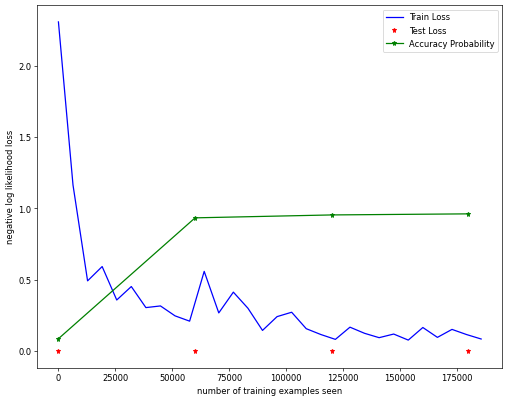

In [31]:
fig=plt.figure(figsize=(10, 8), dpi=60)
x = range(0,log_frequency*len(train_losses)*batch_size_train,log_frequency*batch_size_train)
plt.plot(x, train_losses, color='blue')
x = range(0, TrainLen*len(test_losses), TrainLen)
plt.plot(x,test_losses,'r*')
plt.plot(x,np.array(test_accuracy)/100.0,'g*-')
plt.legend(['Train Loss', 'Test Loss', 'Accuracy Probability'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [32]:
with torch.no_grad():
  output = nnModel(example_X.to(device))

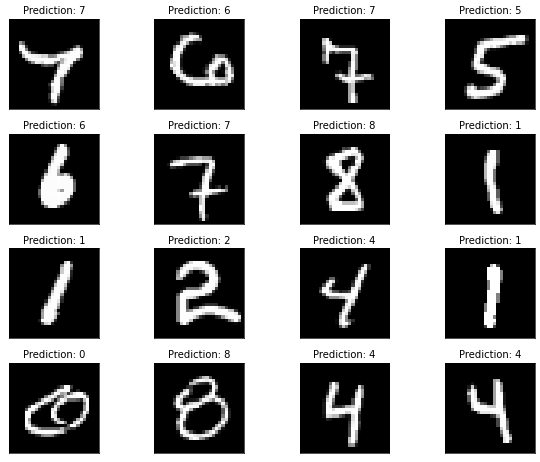

In [33]:
fig=plt.figure(figsize=(10, 8), dpi=60)
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  plt.imshow(example_X[i][0], cmap='gray')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])